In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import mdtraj as md
import mcg
import h5py
import pandas as pd

import matplotlib_config as cfg
import fnmatch
from matplotlib import cm as cmpl
from matplotlib.colors import PowerNorm

from cmap import Colormap

import pickle
import cmasher as cmr
import matplotlib.colors as mcolors 

# Setting the Colormap

In [2]:
cm = Colormap('crameri:lipari')

mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))

truncate_point = 0.1

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

# Loading the data

In [3]:
step2us = 2e-9
burst = 1e5

grade_burst = 10

In [4]:
idx =['0', '1', '2', '3']
coordinate_basefolder = 'TPS_trajectories'
cagedata_basefolder = 'CageData'

coordinate_datafolders = [f'{coordinate_basefolder}/data_mu175_chain0_batch_{idx}' for idx in idx]
cages_datafolders = [f'{cagedata_basefolder}/cages_mu175_chain0_batch_{idx}' for idx in idx]

gro_folder = 'gro_files'

In [5]:
top_file = os.path.join(gro_folder, 'conf.gro')

# Building a dictionary that includes all data

This is done so that for each trajectory al additional information (like shooting point index, mcg, ... is directly linked)

In [6]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'p_sel_sums.npy'))[1:]
    
    # Load the log file
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    # Initialize weights column with zeros
    df['Weights'] = 0.0
    
    # Get successful rows
    successful_indices = df[df['Successful'] == True].index
    
    # Sanity check
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    # Assign weights to successful trajectories
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [7]:

# Dictionary to store all run data
run_data = {}

for datafolder, cagefolder in zip(coordinate_datafolders, cages_datafolders):
    print(f'Loading {datafolder}')
    print(f'Loading {cagefolder}')
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        # Skip non-directories and hidden folders
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        # Initialize entry for this run
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {},
            'trial_rej': {},
            'cages': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        # Process successful trials
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    trial_path = os.path.join(run_folder_path, succ_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    cutoff_mask = mcg_values >= 300
                    B_cutoff = int(frames[np.argmax(cutoff_mask)] / burst) if np.any(cutoff_mask) else None

                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values,
                        'B_cutoff': B_cutoff,
                        'file_path': os.path.join(run_folder_path, f'traj_{trial_num}.dcd')
                    }
                    try:
                        times, _, Cages_512, Cages_62512, Cages_64512, Cages_4151062, _ = np.loadtxt(f'{cagefolder}/{run_folder}/traj_{trial_num}_stride_10_grade.txt', skiprows = 1, unpack = True)
    
                        run_data[datafolder][run_folder]['cages'][trial_num] = {
                        'frames': times,
                        '512': Cages_512,
                        '62512': Cages_62512,
                        '64512': Cages_64512,
                        '4151062': Cages_4151062
                        }
                        cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
                        run_data[datafolder][run_folder]['index_succ'][trial_num]['CageRatio'] = cage_ratio
                    except Exception as cage_error:
                        print(f"Cage data not available for trial {trial_num} in {run_folder}: {cage_error}")
                    

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue
        
        # Process rejected trials
        for rej_file in os.listdir(run_folder_path):
            if rej_file.startswith('rejected_cv_trial_') and not rej_file.endswith('_0.txt'):
                try:
                    trial_num = int(rej_file.split('_')[3].split('.')[0])
                    trial_path = os.path.join(run_folder_path, rej_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    run_data[datafolder][run_folder]['trial_rej'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {rej_file} in {run_folder}: {e}")
                    continue
        


Loading TPS_trajectories/data_mu175_chain0_batch_0
Loading CageData/cages_mu175_chain0_batch_0
Loading TPS_trajectories/data_mu175_chain0_batch_1
Loading CageData/cages_mu175_chain0_batch_1
Loading TPS_trajectories/data_mu175_chain0_batch_2
Loading CageData/cages_mu175_chain0_batch_2
Loading TPS_trajectories/data_mu175_chain0_batch_3
Loading CageData/cages_mu175_chain0_batch_3


# Transition Analysis

In [8]:
plt.rcParams.update({
    'font.size': 18,
    'axes.labelsize': 40,
    'axes.titlesize': 40,
    'xtick.labelsize': 40,
    'ytick.labelsize': 40,
    'legend.fontsize': 14,
    'legend.frameon': False,
    'axes.grid': True
})

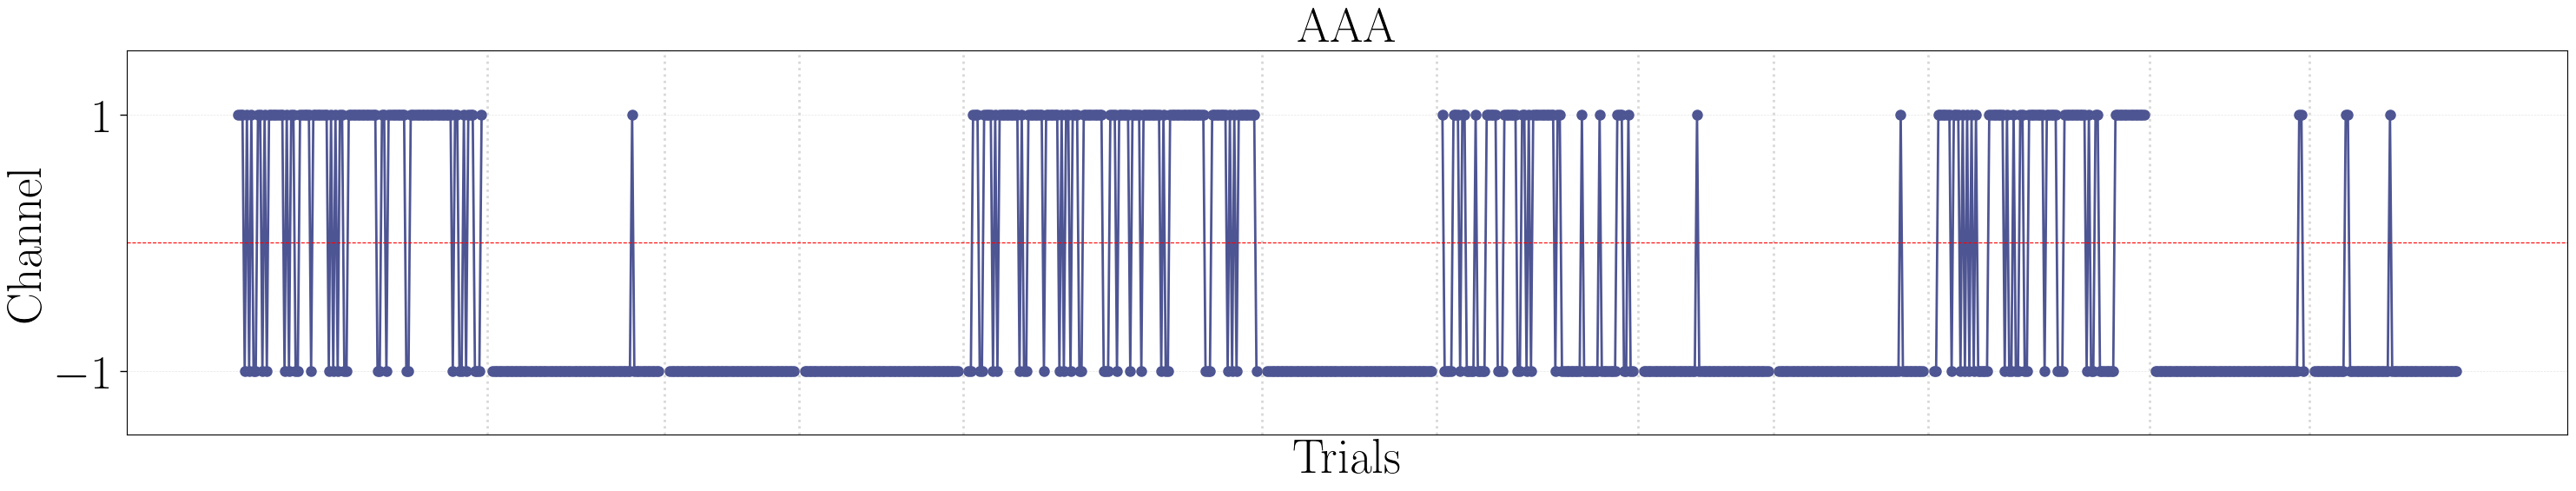

In [9]:
channel_list_all = []
c = 0


plt.figure(figsize=(30, 6))
spacing = 5 
current_x = 0  

for run_idx in range(12):
    channel_list = []
    
    run = f'run_{run_idx}'
    for dataset in coordinate_datafolders:

        for idx in sorted(run_data[dataset][run]['index_succ'].keys()):
            c+=1
            CR = run_data[dataset][run]['index_succ'][idx]['CageRatio']
            # Append discrete values directly to channel_list
            if CR > 1:
                channel_list.append(1)
            elif CR < 1:
                channel_list.append(-1)
            # Note: CR == 1 case is not handled (won't append anything)
    
    x_values = np.arange(len(channel_list)) + current_x
    # Plot discrete values instead of continuous CR
    plt.plot(x_values, channel_list, c=cfg.colors['darkblue'])
    plt.scatter(x_values, channel_list, c=cfg.colors['darkblue'])
    
    current_x = x_values[-1] + spacing if len(x_values) > 0 else current_x + spacing

    if run_idx > 0 and len(x_values) > 0:
        plt.axvline(x=x_values[0] - spacing/2, color='gray', linestyle=':', alpha=0.3)
        
    channel_list_all.append(channel_list)

plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.xlabel('Trials')
plt.ylabel('Channel')
# Set y-axis to only show -1 and 1
plt.yticks([-1, 1])
plt.xticks([])
plt.title("AAA")
plt.ylim(-1.5, 1.5)  # Add some padding for clarity
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig(f'../figures/AAA_channel_switches')
plt.show()

In [22]:
print(f'In total {c} channel switches were counted!')

In total 973 channel switches were counted!


# Saving a list of the Channels!

In [35]:
with open('../Transitions/AA_channels.pkl', 'wb') as f:
    pickle.dump(channel_list_all, f)

# Autocorrelation function

In [23]:
def autocorrelation(data, max_lag=None):
    n = len(data)
    if n == 0:
        return []
    
    # Set default max_lag if not provided
    if max_lag is None:
        max_lag = n - 1
    else:
        max_lag = min(max_lag, n - 1)  # Cannot exceed data length
    
    # Calculate mean and variance
    mean = sum(data) / n
    variance = sum((x - mean) ** 2 for x in data)
    
    # Handle zero variance case
    if variance == 0:
        return [1.0] * (max_lag + 1)
    
    # Precompute deviations from mean
    deviations = [x - mean for x in data]
    
    # Compute autocorrelations
    autocorrs = []
    for lag in range(max_lag + 1):
        numerator = 0.0
        for start in range(n - lag):
            numerator += deviations[start] * deviations[start + lag]
        autocorrs.append(numerator / variance)
    
    return autocorrs

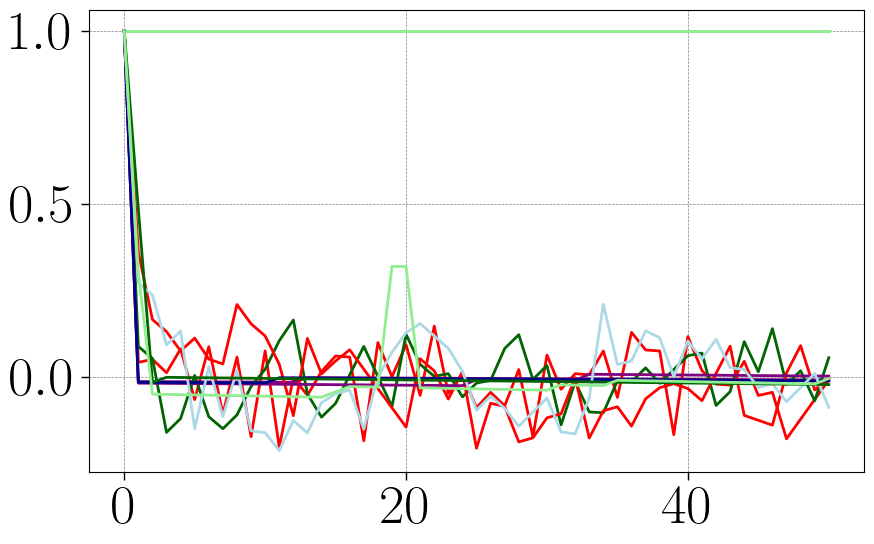

In [32]:
autocorrs = []

for batch in channel_list_all:
    acf = autocorrelation(batch, max_lag = 50)
    plt.plot(acf)
    autocorrs.append(acf)

autocorrs = np.array(autocorrs)
autocorrs_mean = np.mean(autocorrs, axis = 0)

In [33]:
np.save("../Transitions/channel_correlation_AA.npy", autocorrs)

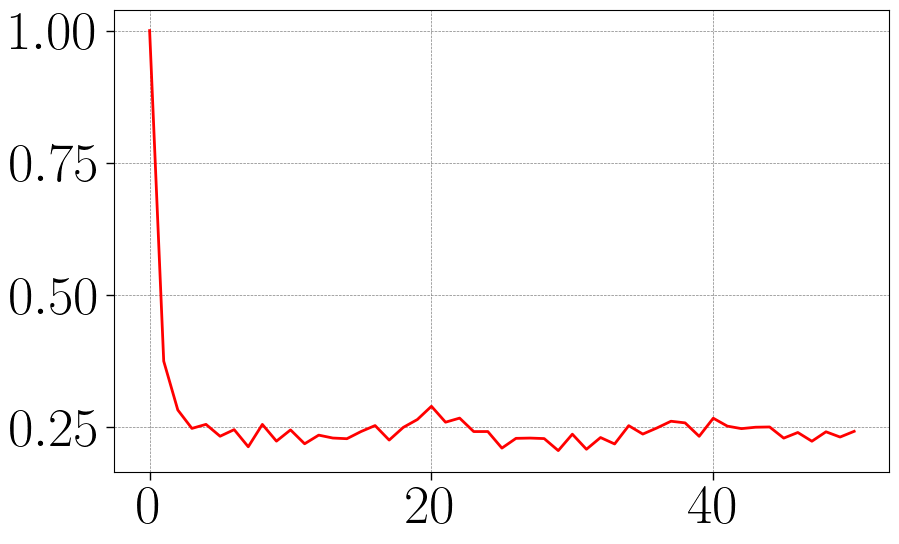

In [34]:
plt.plot(autocorrs_mean)